In [2]:
from ROOT import TLorentzVector
import uproot 
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.figure

Welcome to JupyROOT 6.20/06


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [3]:
# read data files
tree_tt = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_tt.root")["ntuple"]
tree_et = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_et.root")["ntuple"]
tree_mt = uproot.open("/eos/user/s/stcheung/SWAN_projects/Masters_CP/MVAFILE_AllHiggs_mt.root")["ntuple"]

In [4]:
variables = [
    "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
    "aco_angle_1", 
    "mva_dm_1","mva_dm_2",
    "tau_decay_mode_1","tau_decay_mode_2",
#     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
    "pi_px_1", "pi_py_1", "pi_pz_1", "pi_E_1",
    "pi_px_2", "pi_py_2", "pi_pz_2", "pi_E_2",
    "pi0_px_1", "pi0_py_1", "pi0_pz_1", "pi0_E_1",
    "pi0_px_2", "pi0_py_2", "pi0_pz_2", "pi0_E_2",
    "y_1_1", "y_1_2"
]
    

def calcCPAngle(p1: TLorentzVector, p2: TLorentzVector, p3: TLorentzVector, p4: TLorentzVector):
    """
    Calculates CP angle, without shift
    p1 = pi0_1
    p2 = pi0_2
    p3 = pi_1
    p4 = pi_2
    """
    boost = (p3+p4).BoostVector()
    p1.Boost(-boost)
    p2.Boost(-boost)
    p3.Boost(-boost)
    p4.Boost(-boost)
    n1 = p1.Vect() - p1.Vect().Dot(p3.Vect().Unit())*p3.Vect().Unit()
    n2 = p2.Vect() - p2.Vect().Dot(p4.Vect().Unit())*p4.Vect().Unit()
    n1 = n1.Unit()
    n2 = n2.Unit()
    angle = math.acos(n1.Dot(n2))
    sign = p4.Vect().Unit().Dot(n1.Cross(n2))
    if sign<0: angle = 2*math.pi - angle
    return angle

def CPAngle(pi_px_1, pi_py_1, pi_pz_1, pi_E_1, pi_px_2, pi_py_2, pi_pz_2, pi_E_2, pi0_px_1, pi0_py_1, pi0_pz_1, pi0_E_1, pi0_px_2, pi0_py_2, pi0_pz_2, pi0_E_2, y_1_1, y_1_2):
    p1 = TLorentzVector(pi_px_1, pi_py_1, pi_pz_1, pi_E_1)
    p2 = TLorentzVector(pi_px_2, pi_py_2, pi_pz_2, pi_E_2)
    p3 = TLorentzVector(pi0_px_1, pi0_py_1, pi0_pz_1, pi0_E_1)
    p4 = TLorentzVector(pi0_px_2, pi0_py_2, pi0_pz_2, pi0_E_2)
    angle = calcCPAngle(p1, p2, p3, p4)
    
    if y_1_1 * y_1_2 < 0:
        if angle < math.pi: angle += math.pi
        else: angle -= math.pi
    
    return angle

def plotCPAngle(df, dm, bins=100, sample_num=5000):

    plt.rcParams['font.size'] = 14
    
    df_ps = df[(df["rand"]<df["wt_cp_ps"]/2)]
    df_sm = df[(df["rand"]<df["wt_cp_sm"]/2)]
    
    ps = df_ps["calc_aco_angle_1"].sample(sample_num)
    sm = df_sm["calc_aco_angle_1"].sample(sample_num)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
    ax1.hist(ps, bins=bins)
    ax1.hist(sm, bins=bins)
    ax1.set_ylabel('freq')
    ax1.set_xlabel(r'$\phi_{CP}$')
    ax1.set_title('combined ps and sm distribution')
    ax2.hist(ps, bins=bins, color='tab:blue')
    ax2.set_title('ps distribution')
    ax2.set_ylabel('freq')
    ax2.set_xlabel(r'$\phi_{CP}$')
    ax3.hist(sm, bins=bins, color='tab:orange')
    ax3.set_title('sm distribution')
    ax3.set_ylabel('freq')
    ax3.set_xlabel(r'$\phi_{CP}$')
    plt.tight_layout()
    plt.savefig(f"fig/task1/calculated_aco_angle_1_{dm}.png")
    

In [5]:
def rhorhoCPAngle(root_file, dm, verbose=False):
    df = root_file.pandas.df(variables)
    # select only rho-rho events (aco_angle_1 measures rho-rho events)
    df = df[(df['mva_dm_1']==1) & (df['mva_dm_2']==1) & (df["tau_decay_mode_1"] == 1) & (df["tau_decay_mode_2"] == 1)]
    # drop unnecessary labels 
    df_rhorho = df.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2"], axis=1).reset_index(drop=True)
    # find CP angle
    df_rhorho['calc_aco_angle_1'] = df_rhorho.apply(lambda x: CPAngle(x.pi_px_1, x.pi_py_1, x.pi_pz_1, x.pi_E_1, 
                                                                       x.pi_px_2, x.pi_py_2, x.pi_pz_2, x.pi_E_2, 
                                                                       x.pi0_px_1, x.pi0_py_1, x.pi0_pz_1, x.pi0_E_1, 
                                                                       x.pi0_px_2, x.pi0_py_2, x.pi0_pz_2, x.pi0_E_2,
                                                                       x.y_1_1, x.y_1_2), axis=1)
    df_rhorho['residuals'] = df_rhorho['aco_angle_1'] - df_rhorho['calc_aco_angle_1']
    if verbose:
        print(df_rhorho[['aco_angle_1', 'calc_aco_angle_1', 'residuals']])
        # check residuals are small
        print(df_rhorho['residuals'].describe())
    plotCPAngle(df_rhorho, dm, sample_num=10000)

In [1]:
%%time
rhorhoCPAngle(tree_tt, 'tt')

NameError: name 'rhorhoCPAngle' is not defined

# Uncombined methods

In [83]:
# variables to extract
variables = [
    "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
    "aco_angle_1", 
    "mva_dm_1","mva_dm_2",
    "tau_decay_mode_1","tau_decay_mode_2",
#     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
    "pi_px_1", "pi_py_1", "pi_pz_1", "pi_E_1",
    "pi_px_2", "pi_py_2", "pi_pz_2", "pi_E_2",
    "pi0_px_1", "pi0_py_1", "pi0_pz_1", "pi0_E_1",
    "pi0_px_2", "pi0_py_2", "pi0_pz_2", "pi0_E_2",
    "y_1_1", "y_1_2"
]

In [105]:
# only deal with tt data first
df_tt = tree_tt.pandas.df(variables)
# select only rho-rho events (aco_angle_1 measures rho-rho events)
df_tt = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==1) & (df_tt["tau_decay_mode_1"] == 1) & (df_tt["tau_decay_mode_2"] == 1)]
# drop unnecessary labels 
df_tt_rhorho = df_tt.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2"], axis=1).reset_index(drop=True)

In [107]:
df_tt_rhorho['calc_aco_angle_1'] = df_tt_rhorho.apply(lambda x: CPAngle(x.pi_px_1, x.pi_py_1, x.pi_pz_1, x.pi_E_1, 
                                                                       x.pi_px_2, x.pi_py_2, x.pi_pz_2, x.pi_E_2, 
                                                                       x.pi0_px_1, x.pi0_py_1, x.pi0_pz_1, x.pi0_E_1, 
                                                                       x.pi0_px_2, x.pi0_py_2, x.pi0_pz_2, x.pi0_E_2,
                                                                       x.y_1_1, x.y_1_2), axis=1)
df_tt_rhorho['residuals'] = df_tt_rhorho['aco_angle_1'] - df_tt_rhorho['calc_aco_angle_1']
print(df_tt_rhorho[['aco_angle_1', 'calc_aco_angle_1', 'residuals']])

        aco_angle_1  calc_aco_angle_1          diff
0          2.657029          2.657098 -6.812228e-05
1          1.547246          1.547159  8.642635e-05
2          3.750274          3.750331 -5.754366e-05
3          1.192612          1.192824 -2.117337e-04
4          3.264792          3.264791  7.556683e-07
5          5.753096          5.753144 -4.785334e-05
6          2.700190          2.700252 -6.214446e-05
7          3.907006          3.907034 -2.735040e-05
8          1.669376          1.669353  2.370017e-05
9          1.077887          1.077877  9.409454e-06
10         6.073213          6.073216 -3.243284e-06
11         2.413196          2.413368 -1.718009e-04
12         2.236670          2.236698 -2.874584e-05
13         3.952976          3.953104 -1.283458e-04
14         2.338017          2.337995  2.208723e-05
15         3.311521          3.311529 -8.046063e-06
16         5.628795          5.628813 -1.751199e-05
17         2.149978          2.149790  1.883789e-04
18         2

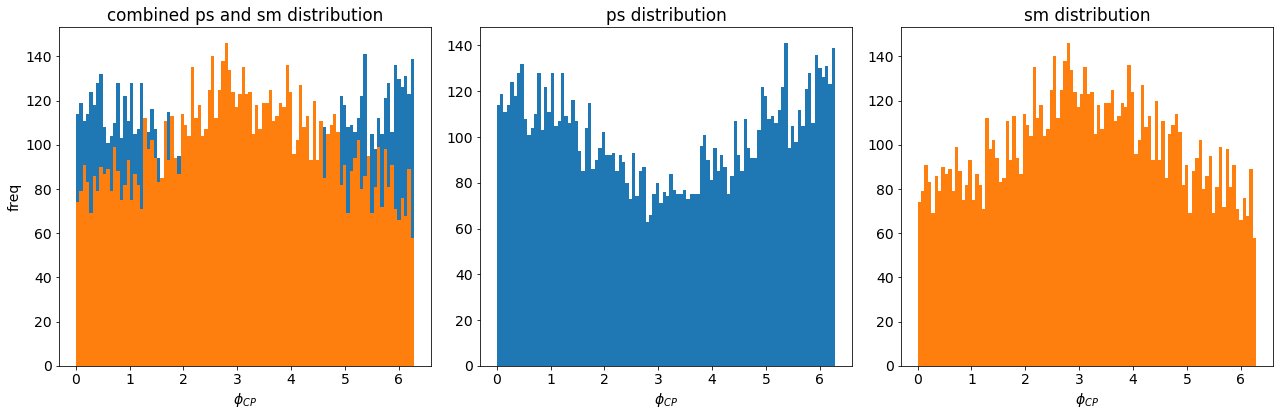

In [166]:
plotCPAngle(df_tt_rhorho, sample_num=10000)

In [165]:
# check residuals are small
print(df_tt_rhorho['residuals'].describe())

count    6.535280e+05
mean    -2.771969e-06
std      1.008684e-03
min     -3.507880e-01
25%     -4.430938e-05
50%      1.747658e-09
75%      4.461731e-05
max      1.720621e-01
Name: diff, dtype: float64


# Even older methods

In [46]:
for _, row in df_tt_rhorho.iterrows():
    p1 = TLorentzVector(row['pi_px_1'], row['pi_py_1'], row['pi_pz_1'], row['pi_E_1'])
    p2 = TLorentzVector(row['pi_px_2'], row['pi_py_2'], row['pi_pz_2'], row['pi_E_2'])
    p3 = TLorentzVector(row['pi0_px_1'], row['pi0_py_1'], row['pi0_pz_1'], row['pi0_E_1'])
    p4 = TLorentzVector(row['pi0_px_2'], row['pi0_py_2'], row['pi0_pz_2'], row['pi0_E_2'])
    
#     print(calcAPAngle(p1, p2, p3, p4))


# p_1 = np.array(df_tt_rhorho[['pi_px_1', 'pi_py_1', 'pi_pz_1']].values)
# E_1 = np.array(df_tt_rhorho[['pi_E_1']].values)
# p_1_four = np.array([TLorentzVector(E, px, py, pz) for px, py, pz in p_1 for E in E_1])

# p_2 = np.array(df_tt_rhorho[['pi_px_2', 'pi_py_2', 'pi_pz_2']].values)
# E_2 = np.array(df_tt_rhorho[['pi_E_2']].values)
# p_2_four = np.array([TLorentzVector(E, px, py, pz) for px, py, pz in p_2 for E in E_2])

def transformLorentzVector(E, px, py, pz):
    return TLorentzVector(E, px, py, pz)

transform_lorentz = np.vectorize(transformLorentzVector)
p_1_four = transform_lorentz(df_tt_rhorho['pi_E_1'].values, df_tt_rhorho['pi_px_1'].values, df_tt_rhorho['pi_py_1'].values, df_tt_rhorho['pi_pz_1'].values)
p_2_four = transform_lorentz(df_tt_rhorho['pi_E_2'].values, df_tt_rhorho['pi_px_2'].values, df_tt_rhorho['pi_py_2'].values, df_tt_rhorho['pi_pz_2'].values)

ZMF_four = p_1_four + p_2_four


# print(ZMF_four)

# boost = ZMF_four[0].BoostVector()
# print(boost)
# p_1_four[0].Boost(-boost)


def calc_velocity(p, m):
    Q = p/m
    v = np.sqrt(Q**2/(1+Q**2))
    return v

def gamma(v):
    return 1/np.sqrt(1-v**2)

def lorentz_transform(four_mom, velocity):
    v_x, v_y, v_z = velocity
    v = np.linalg.norm(v)
    g = gamma(v)
    B = np.array([
        [g, -g*v_x, -g*v_y/c, -g*v_z/c],
        [-g*v_x, 1+(g-1)*v_x**2/v**2, (g-1)*v_x*v_y/v**2, (g-1)*v_x*v_z/v**2],
        [-g*v_y, (g-1)*v_y*v_x/v**2, 1+(g-1)*v_y**2/v**2, (g-1)*v_y*v_z/v**2],
        [-g*v_z, (g-1)*v_z*v_x/v**2, (g-1)*v_z*v_y/v**2, 1+(g-1)*v_z**2/v**2]
    ])
    return B.dot(four_mom)

p = df_tt_rhorho['pi_px_1']

# print(calc_velocity(p, m_pi))